<a href="https://colab.research.google.com/github/NataliaDiaz/colab/blob/master/MI203__td2_tree_and_forest_correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TD: prédiction du vote 2016 aux Etats-Unis par arbres de décisions et méthodes ensemblistes

La séance d'aujourd'hui porte sur la prévision du vote en 2016 aux États-Unis. Précisément, les données d'un recensement sont fournies avec diverses informations par comté à travers les États-Unis. L'objectif est de construire des prédicteurs de leur couleur politique (républicain ou démocrate) à partir de ces données.

Exécuter les commandes suivantes pour charger l'environnement.

In [0]:
%matplotlib inline
from pylab import *
import numpy as np
import os
import random
import matplotlib.pyplot as plt

# Accès aux données

* Elles sont disponibles: https://github.com/stepherbin/teaching/tree/master/ENSTA/TD2

* Charger le fichier the combined_data.csv sur votre drive puis monter le depuis colab


In [4]:
USE_COLAB = True
UPLOAD_OUTPUTS = False
if USE_COLAB:
    # mount the google drive
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    # download data on GoogleDrive
    data_dir = "/content/drive/My Drive/" #teaching/ENSTA/TD_tree/"
else:
    data_dir = "data/" # '.' when running locally avoids error

Mounted at /content/drive


In [0]:
import pandas as pd

census_data = pd.read_csv( os.path.join(data_dir, 'combined_data.csv') )

# Analyse préliminaire des données

Les données sont organisées en champs:
* fips = code du comté à 5 chiffres, le premier ou les deux premiers chiffres indiquent l'état.
* votes = nombre de votants
* etc..

Regarder leur structure, quantité, nature.

Où se trouvent les informations pour former les ensembles d'apprentissage et de test?

Où se trouvent les classes à prédire?

Visualiser quelques distributions.

Le format de données python est décrit ici:
https://pandas.pydata.org/pandas-docs/stable/reference/frame.html


In [6]:
# Exemples de moyens d'accéder aux caractéristiques des données
print(census_data.shape )
print(census_data.columns.values) 
print(census_data['fips'])
print(census_data.head(3))

iattr = 10
attrname = census_data.columns[iattr]
print("Mean of {} is {:.1f}".format(attrname,np.array(census_data[attrname]).mean()))

#########################
## METTRE VOTRE CODE ICI
#########################
print("Nombre de données = {}".format(census_data.shape[0]))
print("Nombre d'attributs utiles = {}".format(census_data.shape[1]-2))

#hist....


(3145, 78)
['fips' 'votes'
 'Percent of adults with less than a high school diploma, 2011-2015'
 'Percent of adults with a high school diploma only, 2011-2015'
 "Percent of adults completing some college or associate's degree, 2011-2015"
 "Percent of adults with a bachelor's degree or higher, 2011-2015"
 'Unemployment_rate_2015' 'POP_ESTIMATE_2015' 'Amish' 'Buddhist'
 'Catholic' 'Christian Generic' 'Eastern Orthodox' 'Hindu' 'Jewish'
 'Mainline Christian' 'Mormon' 'Muslim' 'Non-Catholic Christian' 'Other'
 'Other Christian' 'Other Misc' 'Pentecostal / Charismatic'
 'Protestant Denomination' 'Zoroastrian' 'MedHHInc2014' 'PerCapitaInc'
 'PovertyUnder18Pct2014' 'PovertyAllAgesPct2014' 'Deep_Pov_All'
 'Deep_Pov_Children' 'Population' 'Housing units'
 'Area in square miles - Total area' 'Area in square miles - Water area'
 'Area in square miles - Land area'
 'Density per square mile of land area - Population'
 'Density per square mile of land area - Housing units' 'age_total_pop'
 '0-4_rate

La classe à prédire ('Democrat') n'est décrite que par un seul attribut binaire.
Calculer la répartition des couleurs politiques (quel est a priori la probabilité qu'un comté soit démocrate vs. républicain)

In [8]:
#########################
## METTRE VOTRE CODE ICI
#########################
results = np.array( census_data['Democrat'] )

proba_dem = results.mean()
proba_rep = 1 - proba_dem

print("La probabilité qu'un comté soit démocrate est de {:.2f}%%".format(100*proba_dem))


La probabilité qu'un comté soit démocrate est de 15.45%%


# Préparation du chantier d'apprentissage

On va préparer les ensembles d'apprentissage et de test. 

Pour éviter des problèmes de format de données, on choisit une liste d'attributs utiles dans la liste "feature_cols" ci dessous.

L'ensemble de test sera constitué des comtés d'un seul état.

Info: https://scikit-learn.org/stable/model_selection.html

Liste des états et leurs codes FIPS code (2 digits):
https://en.wikipedia.org/wiki/Federal_Information_Processing_Standard_state_code



In [0]:
## Sous ensembles d'attributs informatifs pour la suite

feature_cols = ['BLACK_FEMALE_rate', 
                'BLACK_MALE_rate',
                'Percent of adults with a bachelor\'s degree or higher, 2011-2015',
                'ASIAN_MALE_rate',
                'ASIAN_FEMALE_rate',
                '25-29_rate',
                'age_total_pop',
                '20-24_rate',
                'Deep_Pov_All',
                '30-34_rate',
                'Density per square mile of land area - Population',
                'Density per square mile of land area - Housing units',
                'Unemployment_rate_2015',
                'Deep_Pov_Children',
                'PovertyAllAgesPct2014',
                'TOT_FEMALE_rate',
                'PerCapitaInc',
                'MULTI_FEMALE_rate',
                '35-39_rate',
                'MULTI_MALE_rate',
                'Percent of adults completing some college or associate\'s degree, 2011-2015',
                '60-64_rate',
                '55-59_rate',
                '65-69_rate',
                'TOT_MALE_rate',
                '85+_rate',
                '70-74_rate',
                '80-84_rate',
                '75-79_rate',
                'Percent of adults with a high school diploma only, 2011-2015',
                'WHITE_FEMALE_rate',
                'WHITE_MALE_rate',
                'Amish',
                'Buddhist',
                'Catholic',
                'Christian Generic',
                'Eastern Orthodox',
                'Hindu',
                'Jewish',
                'Mainline Christian',
                'Mormon',
                'Muslim',
                'Non-Catholic Christian',
                'Other',
                'Other Christian',
                'Other Misc',
                'Pentecostal / Charismatic',
                'Protestant Denomination',
                'Zoroastrian']

filtered_cols = ['Percent of adults with a bachelor\'s degree or higher, 2011-2015',
                'Percent of adults completing some college or associate\'s degree, 2011-2015',
                'Percent of adults with a high school diploma only, 2011-2015',
                'Density per square mile of land area - Population',
                'Density per square mile of land area - Housing units',
                'WHITE_FEMALE_rate',
                'WHITE_MALE_rate',
                'BLACK_FEMALE_rate',
                'BLACK_MALE_rate',
                'ASIAN_FEMALE_rate',
                'Catholic',
                'Christian Generic',
                'Jewish',
                '70-74_rate',
                'D',
                'R']

In [14]:
## 1-state test split

def county_data(census_data, fips_code=17):
  #fips_code 48=Texas, 34=New Jersey, 31=Nebraska, 17=Illinois, 06=California, 36=New York
  mask = census_data['fips'].between(fips_code*1000, fips_code*1000 + 999)
  census_data_train = census_data[~mask]
  census_data_test = census_data[mask]


  XTrain = census_data_train[feature_cols]
  yTrain = census_data_train['Democrat']
  XTest = census_data_test[feature_cols]
  yTest = census_data_test['Democrat']

  return XTrain, yTrain, XTest, yTest

STATE_FIPS_CODE = 17
X_train, y_train, X_test, y_test = county_data(census_data, STATE_FIPS_CODE)

print(X_train.head(2))
print(y_test.head(2))
print(X_train.shape) #(3043, 49)
print(X_test.shape) #(102, 49)

   BLACK_FEMALE_rate  BLACK_MALE_rate  ...  Protestant Denomination  Zoroastrian
0           0.067586         0.062079  ...                        0            0
1           0.067586         0.062079  ...                        0            0

[2 rows x 49 columns]
598    0
599    0
Name: Democrat, dtype: int64
(3043, 49)
(102, 49)



# Apprentissage d'un arbre de décision

On utilisera la bibliothèque scikit learn 

* Construire l'arbre sur les données d'entrainement
* Prédire le vote sur les comtés de test
* Calculer l'erreur et la matrice de confusion

Faire varier certains paramètres (profondeur max, pureté, critère...) et visualisez leur influence.


Info: https://scikit-learn.org/stable/modules/tree.html

Info: https://scikit-learn.org/stable/modules/model_evaluation.html


In [0]:

from sklearn import tree

#########################
## METTRE VOTRE CODE ICI
#########################

clf = tree.DecisionTreeClassifier(criterion="entropy",max_depth=4,min_samples_split=10)
clf = clf.fit( X_train, y_train )

Les instructions suivantes permettent de visualiser l'arbre.
Interpréter le contenu de la représentation.

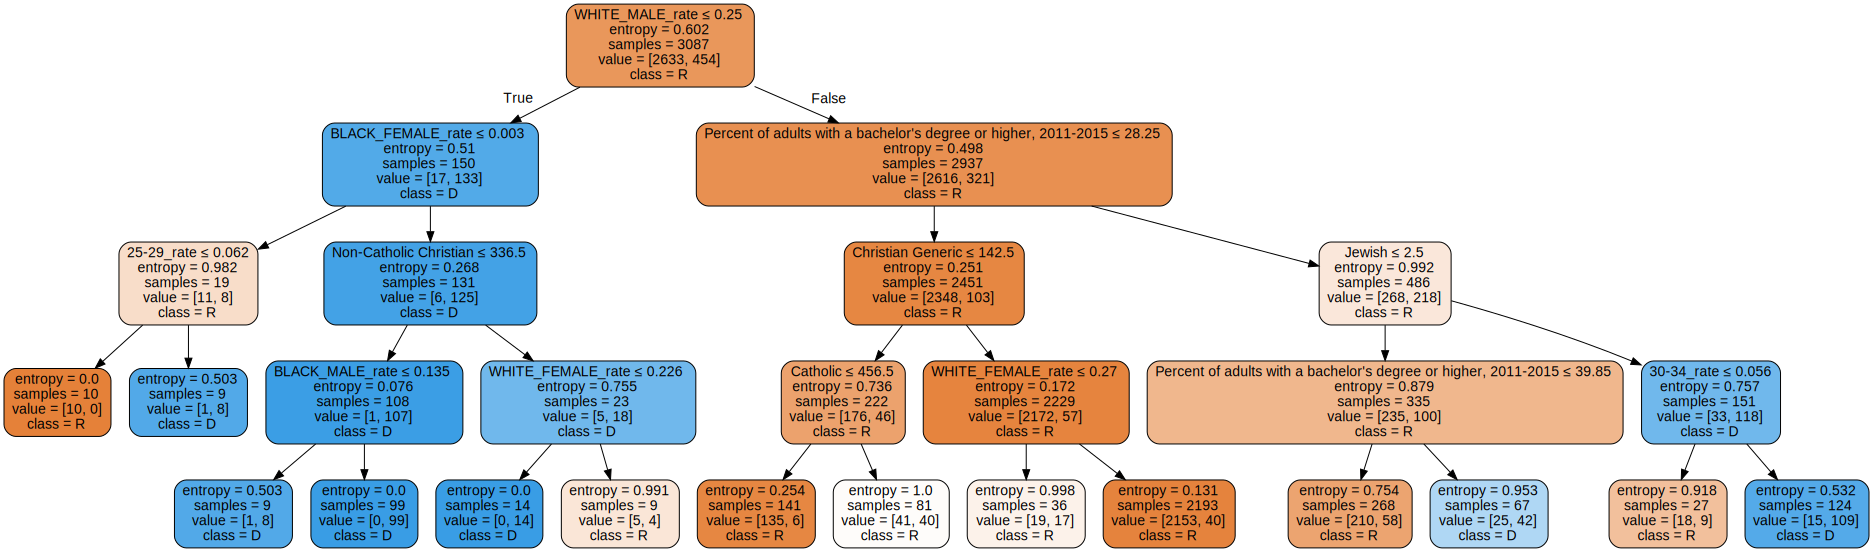

In [33]:
import graphviz

dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 

dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=X_train.columns.values,  
                     class_names=["R","D"],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

In [34]:
# Prédiction et évaluation

#########################
## METTRE VOTRE CODE ICI
#########################

preds = clf.predict(X_test)
print('Predictions per county in state #'+ str(STATE_FIPS_CODE) + ' are ' + str(preds ) )
print('Votes per county in state #'+ str(STATE_FIPS_CODE) + ' are ' + str(list(y_test) ) )

import sklearn.metrics as perf

oa = perf.accuracy_score(y_test, preds)
bas = perf.balanced_accuracy_score(y_test, preds)
print(oa,bas)
cm = perf.confusion_matrix(y_test, preds)
print(cm)

Predictions per county in state #17 are [1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1
 1 0 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0]
Votes per county in state #17 are [1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0]
0.7241379310344828 0.75
[[26  0]
 [16 16]]



---

# Bagging

L'objectif de cette partie est de construire **à la main** une approche de bagging.

Le principe de l'approche est de:

* Apprendre et collecter plusieurs arbres sur des échantillonnages aléatoires des données d'apprentissage
* Agréger les prédictions par vote 
* Evaluer: Les prédictions agrégées
* Comparer avec les arbres individuels et le résultat précédent


Utiliser les fonctions de construction d'ensemble d'apprentissage/test de scikit-learn https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html pour générer les sous-esnembles échantillonnés.

**Comparer après le cours** les fonctions de scikit-learn: https://scikit-learn.org/stable/modules/ensemble.html

Numpy tips: [np.arange](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.arange.html), [numpy.sum](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.sum.html), [numpy.mean](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.mean.html), [numpy.where](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.where.html)

In [0]:
from sklearn.model_selection import train_test_split

# Données d'apprentissage: X_train, y_train, idx_train
# Données de test: X_test, y_test, idx_test
# Les étapes de conception du prédicteur (apprentissage) sont les suivantes:
#   - Construction des sous-ensembles de données
#   - Apprentissage d'un arbre
#   - Agrégation de l'arbre dans la forêt
#
# Pour le test


def learn_forest(XTrain, yTrain, nb_trees, depth=15):

#########################
## METTRE VOTRE CODE ICI
#########################

  forest = []
  singleperf=[]

  for ss in range(nb_trees):
    # bagging for subset
    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
        XTrain, yTrain, test_size=0.2 )

    # single tree training
    clf = tree.DecisionTreeClassifier(max_depth=depth, splitter="random")
    clf = clf.fit( X_train_sub, y_train_sub )
    
    # grow the forest
    forest.append( clf )
  
    # single tree evaluation
    curr_train_pred=clf.predict(X_train_sub)
    curr_test_pred=clf.predict(X_test_sub)
    singleperf.append([perf.balanced_accuracy_score( y_train_sub, curr_train_pred ), perf.balanced_accuracy_score( y_test_sub,curr_test_pred)])
  
  return forest,singleperf



In [0]:
def predict_forest(forest, XTest, yTest = None):
  
#########################
## METTRE VOTRE CODE ICI
#########################
  singleperf=[]
  all_preds=[]
  nb_trees = len(forest)
  for ss in forest:# nb_trees
    test_pred=ss.predict(XTest)
    all_preds.append(test_pred)

    if (yTest is not None):
      singleperf.append(perf.balanced_accuracy_score( yTest, test_pred ))

  all_preds=np.array(all_preds)
  #print(all_preds)  # A 2x2 matrix of 0/1

  # Vote
  gloup = np.sum(all_preds, axis=0)
  final_pred = np.where(gloup > nb_trees/2, 1, 0) # why not max?
#   print(gloup)
#   print(final_pred)
#   [19  4  3 10  3  7 18  0 10 10  0 11 10  1  6 10  0  1 18 13 18  0  6 14
#   1  5 15 13  6 16 12  6 11 16  5  9 17 19 11 15 17 15 17 15  5  0  4 15
#  13 10  9  0  0  8  1 16 17  4]
#  [1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 1 0 1 1 0 1 1 0 0 1
#  1 1 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0]

  if (yTest is not None):
    return final_pred,singleperf
  else:
    return final_pred


In [27]:
#########################
## METTRE VOTRE CODE ICI
#########################


X_train, y_train, X_test, y_test = county_data(census_data, 6)

F,singleperf = learn_forest(X_train, y_train, 20, depth=15)
pred, singleperftest = predict_forest(F, X_test, y_test)
acc = perf.balanced_accuracy_score( y_test, pred )
print("Taux de bonne prédiction final = {:.2f}%".format(100*acc))
print("Moyenne des bonnes prédictions individuelles = {:.2f}%".format(100*mean(singleperftest)))
#print(singleperftest)
#print(singleperf)

[[1 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [1 0 0 ... 0 1 0]
 ...
 [1 0 0 ... 1 0 0]
 [1 1 0 ... 1 1 0]
 [1 0 0 ... 1 1 0]]
Taux de bonne prédiction final = 74.40%
Moyenne des bonnes prédictions individuelles = 67.82%
